In [1]:
%load_ext autoreload
%autoreload 2

# Run the model on the audio files 

In [3]:
import numpy as np
import torch
import yaml
import itertools
import glob
import pandas as pd

from torch.quantization import quantize_dynamic
from torch.utils.data import DataLoader, Dataset

from utils.utils_testing import AudioList, AudioLoader
from utils.parsing_utils import parseFolders

from model.custom_model import CustomAudioCLIP


def getTestLoader(list_arrays):
    list_preds = AudioLoader(list_arrays)
    predLoader = DataLoader(list_preds, batch_size=1, num_workers=4, pin_memory=False)
    return predLoader

def predict(testLoader, model):

    proba_list = []

    for array in testLoader:
        tensor = array
        output = model(tensor)
        output = np.exp(output.detach().numpy())
        proba_list.append(output[0][1])

    return (np.array(proba_list))

def initModel(model_path):
    model = CustomAudioCLIP(num_target_classes=2)
    model = model.load_from_checkpoint(model_path, num_target_classes=2)
    model.eval()

    # m = torch.load(model_path).eval()
    # m_q = quantize_dynamic(m, qconfig_spec={torch.nn.Linear, torch.nn.Conv2d}, dtype=torch.qint8)
    return model

In [4]:
label_path = "/Data/test_dataset/labels"
audio_test_path = "/Data/test_dataset/audio"
mpath = "/app/assets/ckpt-epoch=10-val_loss=0.09.ckpt"

l_segments = 3
overlap = 0
time_index = 0
threshold = 0.9

In [5]:
flist = parseFolders(audio_test_path, label_path)

Found 67 audio files with valid result file.


In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

m = initModel(mpath)

def get_preds_and_gt(item):

    gt = []
    preds = []

    audio = item['audio']
    result = item['result']

    # Get the prediction scores
    l_audio = AudioList().get_processed_list(audio)
    test_loader = getTestLoader(l_audio[0])
    p = predict(test_loader, m)
    preds.append(p)

    # Get the ground truth
    df = pd.read_csv(result, sep='\t')

    for segment in range(len(l_audio[0])):

        is_in_df = len(df[(segment <= df['End Time (s)']) & (df['Begin Time (s)'] <= segment)])

        if is_in_df:
            gt.append(1)
        else: 
            gt.append(0)

    return (gt, preds)

def get_auc_roc_fig(gt_array, preds_arr, title):
    
    fpr, tpr, _ = roc_curve(gt_array, preds_arr)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

In [8]:
###################################
# ANALYSIS FOR ALL THE TEST FILES #
###################################

gt_all = []
preds_all = []

for item in flist:
    gt, preds = get_preds_and_gt(item)
    gt_all.append(gt)
    preds_all.append(preds)

/usr/local/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/app/model/custom_model.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)
/usr/local/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/app/model/custom_model.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)
/usr/local/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)
/app/model/custom_model.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_sof

# PLOT RESULTS

In [14]:
def binarise(preds_array, threshold):

    predicted_labels = []

    for proba in preds_array:
        if proba > threshold:
            predicted_labels.append(1)
        else:
            predicted_labels.append(0)
            
    return predicted_labels

def get_confusion_matrix(gt, preds, threshold=0.9):

    b_preds = binarise(preds, threshold)
    print(confusion_matrix(gt, b_preds))

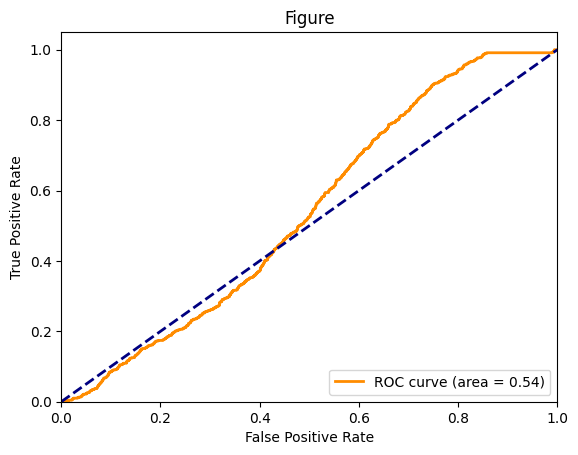

In [15]:
import itertools
gt_all_all = list(itertools.chain.from_iterable(gt_all))
preds_all_all = list(itertools.chain.from_iterable(preds_all))

get_auc_roc_fig(gt_all_all, np.concatenate(preds_all_all), "Figure")

In [13]:
get_confusion_matrix(gt_all_all, np.concatenate(preds_all_all), threshold = 0.9)

NameError: name 'confusion_matrix' is not defined

In [104]:
##################################
# For each individual test files #
##################################

In [123]:
flist[18]

{'audio': '/Data/test_dataset/audio/YELLMJ23_20120229_145427.MP3016.mp3',
 'result': '/Data/test_dataset/labels/YELLMJ23_20120229_145427.MP3009.Table.1.selections.txt'}

In [124]:
df = pd.read_csv(flist[18]['result'], sep='\t')
df

,Selection,View,Channel,Begin Time (s),End Time (s),Low Freq (Hz),High Freq (Hz),Delta Time (s),type,comment
0,1,Waveform 1,1,781.066967,813.554812,0.0,22050.0,32.4878,helicopter,NaN
1,1,Spectrogram 1,1,781.066967,813.554812,0.0,22050.0,32.4878,helicopter,NaN


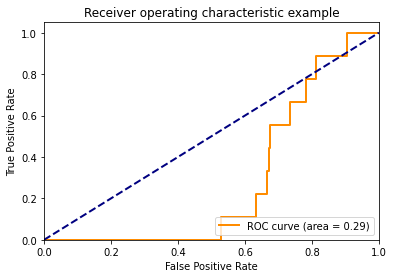

In [106]:
get_auc_roc_fig(gt_all[10], np.concatenate(preds_all[10]))

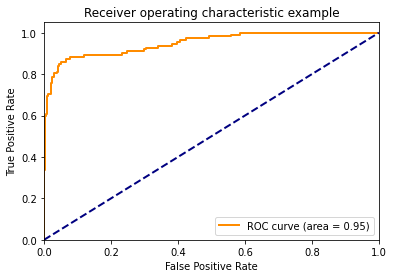

In [111]:
get_auc_roc_fig(gt_all[5], np.concatenate(preds_all[5]))

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


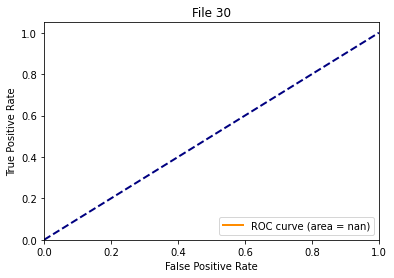

In [13]:
get_auc_roc_fig(gt_all[34], np.concatenate(preds_all[34]), title = "File 30")

In [134]:
from sklearn.metrics import confusion_matrix

# Confusion matrix from sklearn:

| tn | fp | 

| fn | tp |

In [147]:
get_confusion_matrix(gt_all[5], preds_all[5][0])

[[464  23]
 [ 17  95]]


In [148]:
get_confusion_matrix(gt_all[26], preds_all[26][0])

[[478 111]
 [  3   7]]


In [152]:
get_confusion_matrix(gt_all[1], preds_all[1][0])

[[167 432]
 [  0   0]]


In [153]:
flist[1]

{'audio': '/Data/test_dataset/audio/YELLHLBC_20130204_122047.MP3002.mp3',
 'result': '/Data/test_dataset/labels/YELLHLBC_20130204_122047.MP3002.Table.1.selections.txt'}